# 8. Predict 2045 Crash Risks - (2014-2018 as training data) 

After the 2019 crash data is available, models are retrained with 2014-2018 data and tested on 2019 data. This notebook gives an example of how to use the models to predict crash risk, for example, use the model to predict crash risks for the LRTP 2045 preferred scenario. The prediction results can be used for assignments such as transportation safety assessment, scenario comparison and long-range transportation plan.

<a id='sections'></a>
**Sections**

- [**Predict 2045 Crash Risks - (2014-2018 as training data)**](#predict-2045-crash-risks)
    - [RuraL Area](#rural-area)
        - Binary Model
        - Multiclass Model
        - Binary Model + Multiclass Model
            - Predicted 2045
            - Predicted 2045 VS Predicted 2019
    - [Urban Area](#urban-area)  
        - Binary Model
        - Multiclass Model
        - Binary Model + Multiclass Model
            - Predicted 2045
            - Predicted 2045 VS Predicted 2019

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import pickle
from numpy import argmax
import importlib
import collections
import time
import getpass
import datetime as datetime
from shapely import wkt
from matplotlib import pyplot as plt

import plotly.express as px
import geopandas as gpd
import shapely.geometry

import categorical_embedder as ce
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer,  LabelEncoder
from sklearn.linear_model import LinearRegression,  LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE,SMOTENC
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, brier_score_loss, auc
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix, make_scorer, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import  StratifiedKFold, KFold, cross_val_score, StratifiedShuffleSplit
from sklearn.model_selection import  RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn import metrics
from xgboost import XGBClassifier

Using TensorFlow backend.
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\xl43843\Anaconda3\en

In [2]:
# import modules
import sys; sys.path.insert(0, '..')
import src.models
import src.multiclass_models
# importlib.reload (src.multiclass_models)
from src.models import *
from src.multiclass_models import *

In [3]:
base_gis_dir  = "G:/CUUATS/Safety Forecasting Tool/"
base_file_dir = "L:/Safety Forecasting Tool/"
base_tool_dir = "L:/Safety_Crash Data Analysis/"

In [4]:
from src.data_preprocessing import geo_segmentid
with open(base_file_dir+'data/interim/roadway/data_source/streets.pkl', 'rb') as f:
    streets = pickle.load(f)
# Project PCD roadway segments to epsg:3435
geo_SegmentID = geo_segmentid(streets)

# Rural Area
[[back to top](#sections)]
<a id='rural-area'></a>

In [5]:
with open(base_file_dir+'data/processed/df_rural_train_2014_2018.pkl', 'rb') as f:
    df_rural_train_2014_2018 = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_train_label_2014_2018.pkl', 'rb') as f:
    df_rural_train_label_2014_2018 = pickle.load(f)
    
with open(base_file_dir+'data/processed/df_rural_test_2019.pkl', 'rb') as f:
    df_rural_test_2019 = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_test_label_2019.pkl', 'rb') as f:
    df_rural_test_label_2019 = pickle.load(f)
    
with open(base_file_dir+'data/processed/rural_2045_2019.pkl', 'rb') as f:
    df_rural_test_2045 = pickle.load(f)

In [6]:
# convert PC into a ordinal numeric field
df_rural_train_2014_2018=func_PC_numeric(df_rural_train_2014_2018)
df_rural_test_2019=func_PC_numeric(df_rural_test_2019)
df_rural_test_2045=func_PC_numeric(df_rural_test_2045)
# Remove features that should not be fed into the model
remove_list=['segment_id','overlap','geometry','Year']
targetlist = [i for i in list(df_rural_train_2014_2018.columns) if i not in remove_list]
df_rural_train_sub_2014_2018 = df_rural_train_2014_2018[targetlist]
df_rural_test_sub_2019 = df_rural_test_2019[targetlist]
df_rural_test_sub_2045 = df_rural_test_2045[targetlist]
df_rural_test_sub_2045.loc[df_rural_test_sub_2045['intersection_control_type']==' ','intersection_control_type']='None'

In [7]:
df_rural_train_binary_label_2014_2018=df_rural_train_label_2014_2018.mask(df_rural_train_label_2014_2018 >= 1, 1)
df_rural_train_cat_label_2014_2018=df_rural_train_label_2014_2018.mask(df_rural_train_label_2014_2018 >= 3, 2)

df_rural_test_binary_label_2019=df_rural_test_label_2019.mask(df_rural_test_label_2019 >= 1, 1)
df_rural_test_cat_label_2019=df_rural_test_label_2019.mask(df_rural_test_label_2019 >= 3, 2)

print(collections.Counter(df_rural_train_binary_label_2014_2018))
print(collections.Counter(df_rural_test_binary_label_2019))
print(collections.Counter(df_rural_train_cat_label_2014_2018))
print(collections.Counter(df_rural_test_cat_label_2019))

Counter({0.0: 26409, 1.0: 2111})
Counter({0.0: 5327, 1.0: 377})
Counter({0.0: 26409, 1.0: 1582, 2.0: 529})
Counter({0.0: 5327, 1.0: 263, 2.0: 114})


In [8]:
X_train_2014_2018 = df_rural_train_sub_2014_2018
y_train_binary_2014_2018 = df_rural_train_binary_label_2014_2018
y_train_cat_2014_2018 = df_rural_train_cat_label_2014_2018

X_test_2019 = df_rural_test_sub_2019
y_test_binary_2019 = df_rural_test_binary_label_2019
y_test_cat_2019 = df_rural_test_cat_label_2019

X_test_2045 = df_rural_test_sub_2045

OHfname = func_OHtransformed_var(X_train_2014_2018)
X_train_OHtransformed_2014_2018=func_OHtransform_var(X_train_2014_2018)
X_test_OHtransformed_2019=func_OHtransform_var(X_test_2019)
X_test_OHtransformed_2045=func_OHtransform_var(X_test_2045)

In [9]:
model_name = 'rural_binary_XGB_trainedw2014_2018_best_thres0.362.pkl'
with open(base_file_dir+'/models/segment/rural/binary/'+ model_name, 'rb') as f:
    rural_binary_xgb = pickle.load(f)
    
model_name = 'rural_multiclass_XGB_trainedw2014_2018.pkl'
with open(base_file_dir+'/models/segment/rural/multiclass/'+ model_name, 'rb') as f:
    rural_multiclass_xgb = pickle.load(f)

## Binary Model
[[back to top](#sections)]

In [10]:
# Use the predefined best_thres
best_thres = 0.362

y_test_pred_porba_2019  = rural_binary_xgb.predict_proba(X_test_OHtransformed_2019)[:,1]
Binary_y_pred_2019 = [1 if y>=best_thres else 0 for y in y_test_pred_porba_2019]

y_test_pred_porba_2045  = rural_binary_xgb.predict_proba(X_test_OHtransformed_2045)[:,1]
Binary_y_pred_2045 = [1 if y>=best_thres else 0 for y in y_test_pred_porba_2045]


Text(0.5, 1.0, 'rural_XGB-Binary_predicted_2045')

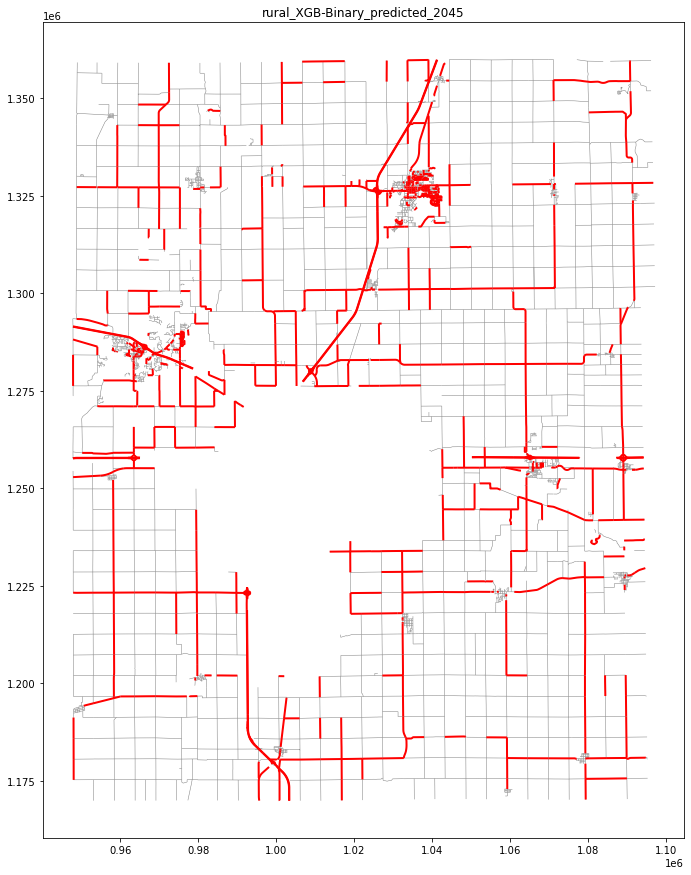

In [11]:
year = 2045
segment_intersection='segment'
model_geography='rural'
model_name = 'XGB-Binary'
map_name = model_geography+'_'+model_name+'_predicted_'+str(year)
fig, ax = plt.subplots(figsize=(15,15))
# prediction_binary_maps (ax,geo_SegmentID, df_rural_test_2045, Binary_y_pred_2045, year)
prediction_binary_maps (ax,df_rural_test_2045, df_rural_test_2045, Binary_y_pred_2045, year)
plt.title(map_name)

Text(0.5, 1.0, 'rural_XGB-Binary_predicted_2045\n by_roadway_functional_class')

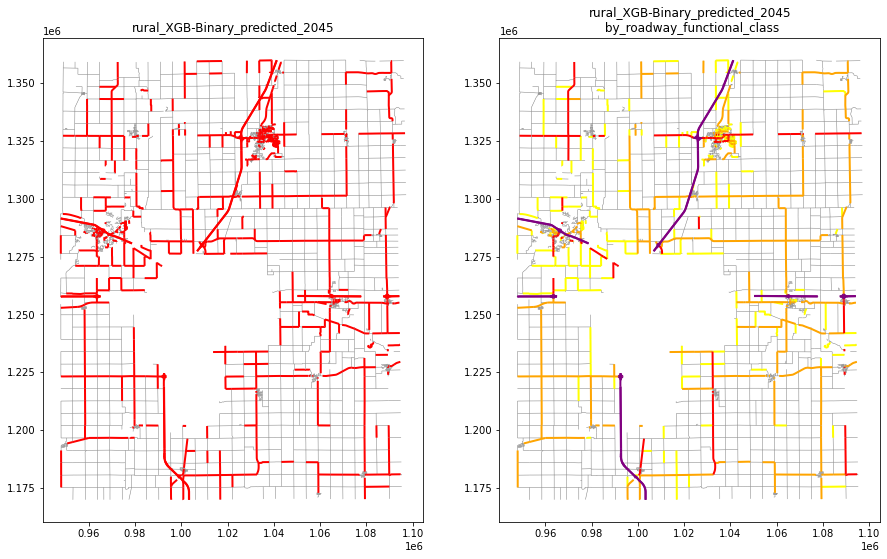

In [12]:
year = 2045
segment_intersection='segment'
model_geography='rural'
model_name = 'XGB-Binary'
map_name = model_geography+'_'+model_name+'_predicted_'+str(year)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
df_rural_test_2045  = gpd.GeoDataFrame(df_rural_test_2045 , geometry=df_rural_test_2045['geometry'])
prediction_binary_maps (ax1,df_rural_test_2045, df_rural_test_2045, Binary_y_pred_2045, year)
ax1.set_title(map_name)
prediction_binary_maps_byrdclass (ax2,df_rural_test_2045, df_rural_test_2045, Binary_y_pred_2045, year)
ax2.set_title(map_name+'\n by_roadway_functional_class')

## Multi-class Model
[[back to top](#sections)]

In [13]:
# Multiclass model prediction results
Multiclass_y_pred_2019 = rural_multiclass_xgb.predict(X_test_OHtransformed_2019) 
Multiclass_y_pred_2045 = rural_multiclass_xgb.predict(X_test_OHtransformed_2045) 

Text(0.5, 1.0, 'rural_XGB-MultiClass_predicted_2045')

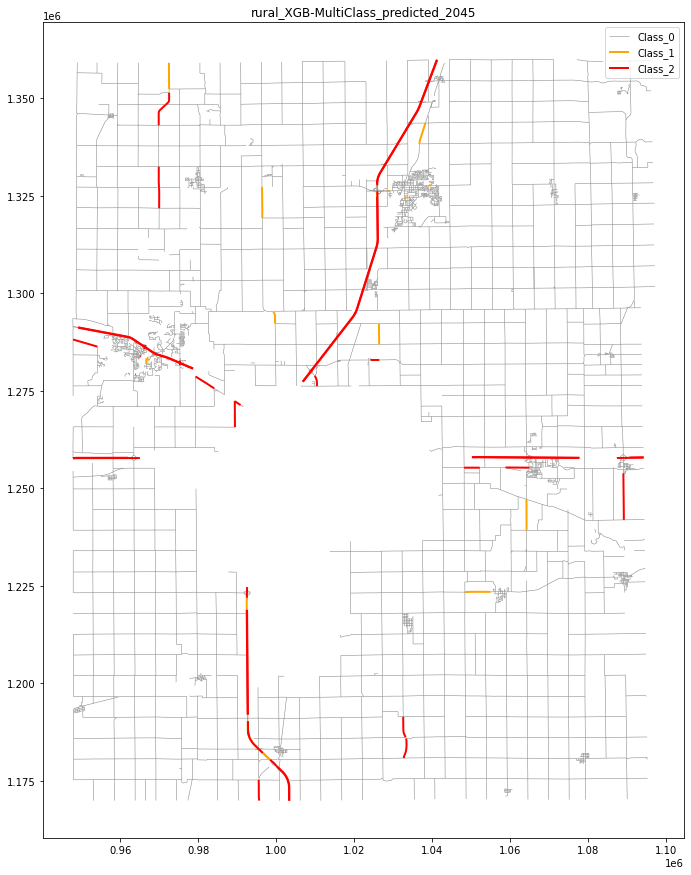

In [14]:
year = 2045
segment_intersection='segment'
model_geography='rural'
model_name = 'XGB-MultiClass'
map_name = model_geography+'_'+model_name+'_predicted_'+str(year)
fig, axes = plt.subplots(figsize=(15,15))
plt_multiclass_prediction_maps (axes, df_rural_test_2045, Multiclass_y_pred_2045, year)
plt.title(map_name)

## Binary Model + Multiclass Model
[[back to top](#sections)]

### Predict 2045
[[back to top](#sections)]

In [15]:
BinaryMulticlass_results = df_rural_test_2045.loc[:,['segment_id','geometry']].copy()
BinaryMulticlass_results['Binary'] = Binary_y_pred_2045
BinaryMulticlass_results['MultiClass'] = Multiclass_y_pred_2045

risklevelcounts_2045 = pd.crosstab(BinaryMulticlass_results['Binary'],BinaryMulticlass_results['MultiClass'])
print('Number of low risk roads:',risklevelcounts_2045.loc[0,0])
print('Number of medium risk roads:',risklevelcounts_2045.sum().sum() - risklevelcounts_2045.loc[0,0] - risklevelcounts_2045.loc[1,2])
print('Number of high risk roads:',risklevelcounts_2045.loc[1,2],'\n')

risklevelcounts_2045

Number of low risk roads: 4684
Number of medium risk roads: 936
Number of high risk roads: 70 



MultiClass   0.0  1.0  2.0
Binary                    
0           4684    0    0
1            917   19   70

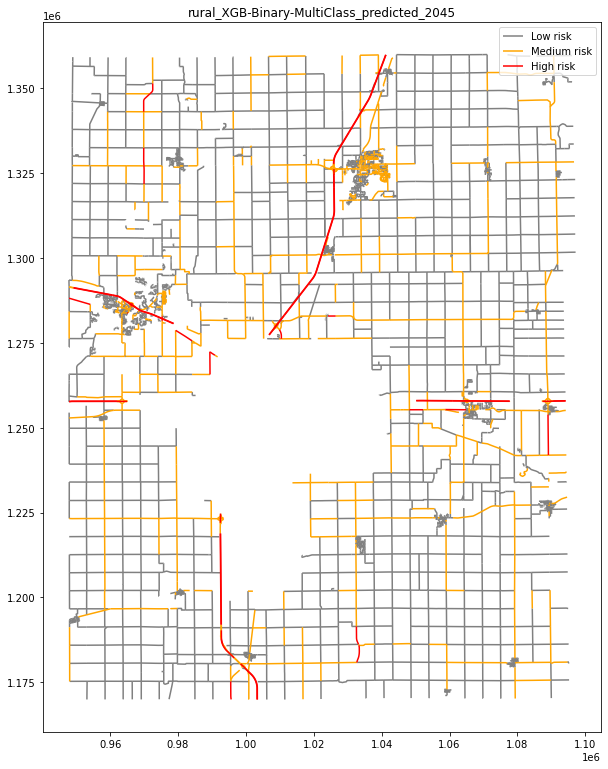

In [16]:
# map low risk, medium risk, high risk roads
year = 2045
segment_intersection='segment'
model_geography='rural'
model_name = 'XGB-Binary-MultiClass'
map_name = model_geography+'_'+model_name+'_predicted_'+str(year)

plt_low_medium_high_risk_roads(BinaryMulticlass_results,map_name)

### Predicted 2045 VS Predicted 2019
[[back to top](#sections)]

In [17]:
BinaryMulticlass_results = df_rural_test_2019.loc[:,['segment_id','geometry']].copy()
BinaryMulticlass_results['Binary'] = Binary_y_pred_2019
BinaryMulticlass_results['MultiClass'] = Multiclass_y_pred_2019

risklevelcounts_2019 = pd.crosstab(BinaryMulticlass_results['Binary'],BinaryMulticlass_results['MultiClass'])
print('Number of low risk roads:',risklevelcounts_2019.loc[0,0])
print('Number of medium risk roads:',risklevelcounts_2019.sum().sum() - risklevelcounts_2019.loc[0,0] - risklevelcounts_2019.loc[1,2])
print('Number of high risk roads:',risklevelcounts_2019.loc[1,2],'\n')

risklevelcounts_2019

Number of low risk roads: 4722
Number of medium risk roads: 918
Number of high risk roads: 64 



MultiClass   0.0  1.0  2.0
Binary                    
0           4722    0    0
1            888   30   64

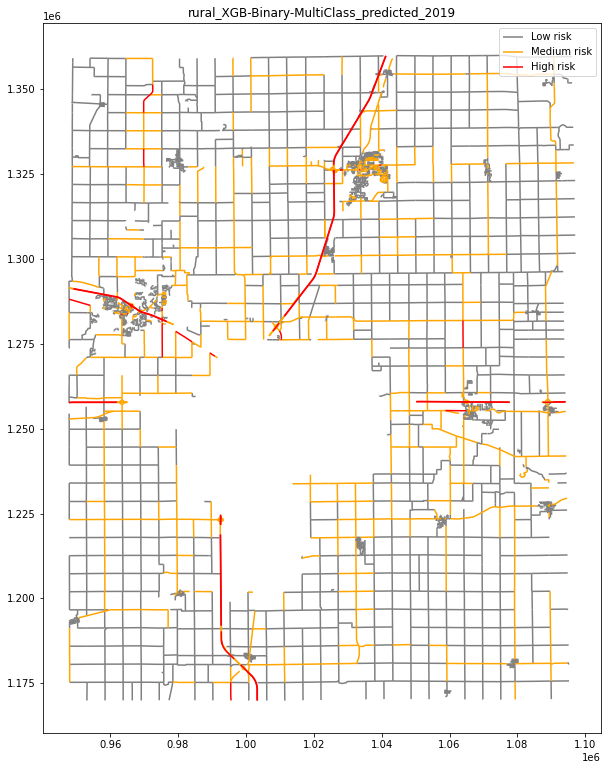

In [18]:
# map low risk, medium risk, high risk roads
year = 2019
segment_intersection='segment'
model_geography='rural'
model_name = 'XGB-Binary-MultiClass'
map_name = model_geography+'_'+model_name+'_predicted_'+str(year)

plt_low_medium_high_risk_roads(BinaryMulticlass_results,map_name)

# Urban Area
[[back to top](#sections)]
<a id='urban-area'></a>

In [19]:
with open(base_file_dir+'data/processed/df_urban_train_2014_2018.pkl', 'rb') as f:
    df_urban_train_2014_2018 = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_train_label_2014_2018.pkl', 'rb') as f:
    df_urban_train_label_2014_2018 = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_test_2019.pkl', 'rb') as f:
    df_urban_test_2019 = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_test_label_2019.pkl', 'rb') as f:
    df_urban_test_label_2019 = pickle.load(f)
    
with open(base_file_dir+'data/processed/urban_2045_2019.pkl', 'rb') as f:
    df_urban_test_2045 = pickle.load(f)

In [20]:
# convert PC into a ordinal numeric field
df_urban_train_2014_2018=func_PC_numeric(df_urban_train_2014_2018)
df_urban_test_2019=func_PC_numeric(df_urban_test_2019)
df_urban_test_2045=func_PC_numeric(df_urban_test_2045)
# Remove features that should not be fed into the model
remove_list=['segment_id','overlap','geometry','Year']
targetlist = [i for i in list(df_urban_train_2014_2018.columns) if i not in remove_list]
df_urban_train_sub_2014_2018 = df_urban_train_2014_2018[targetlist]
df_urban_test_sub_2019 = df_urban_test_2019[targetlist]
df_urban_test_sub_2045 = df_urban_test_2045[targetlist]

In [21]:
c = 'lane_configuration'
print(pd.unique(df_urban_test_sub_2019[c]))
print(pd.unique(df_urban_test_sub_2045[c]))
print(set(pd.unique(df_urban_test_sub_2019[c]))-set(pd.unique(df_urban_test_sub_2045[c])))
print(set(pd.unique(df_urban_test_sub_2045[c]))-set(pd.unique(df_urban_test_sub_2019[c])))

['None_TT' 'XT' 'XLTR' 'XLT' 'XMT' 'XLR' 'XMTR' 'XLRT' 'XXLTTR' 'XTR'
 'XXLTT' 'X' 'XXTT' 'XXMTT' 'XXMTTR' 'XXLR' 'XX' 'XXLT' 'XXLTQ' 'XXLLTTR'
 'XXLLTT' 'XR' 'XXT' 'XXLLR' 'LTQ' 'LTTR' 'TT' 'XKT' 'XXTTR' 'XXLTTQ'
 'XXXLTT' 'XXXXTT' 'XXLTR' 'LT' 'T' 'LTR' 'XLTQ' 'XTT' 'XLQ' 'XKR']
['None_TT' 'XT' 'XLTR' 'XLT' 'XMT' 'XLR' 'XTR' 'XMTR' 'XLRT' 'XXLTTR'
 'XXLLTR' 'XXTTR' 'XXLTT' 'X' 'XXTT' 'XXMTT' 'XXMTTR' 'XXLTR' 'XXLR'
 'XXTR' 'XX' 'LTTR' 'KTR' 'XXLT' 'XXXTTR' 'XXLLTT' 'XLLQ' 'XR' 'XXT'
 'XXLLR' 'LTQ' 'TTR' 'TT' 'XXTTQ' 'XXLTTQ' 'XXXLTT' 'XXLLTQ' 'LT' 'T'
 'LTR' 'XLTQ' 'XTT' 'XLQ' 'XKR']
{'XKT', 'XXLTQ', 'XXXXTT', 'XXLLTTR'}
{'XXXTTR', 'KTR', 'XXLLTQ', 'TTR', 'XXTTQ', 'XXTR', 'XXLLTR', 'XLLQ'}


In [22]:
df_urban_test_sub_2045.loc[df_urban_test_sub_2045['intersection_control_type']==' ','intersection_control_type']='None'
df_urban_test_sub_2045.loc[df_urban_test_sub_2045['lane_configuration'].isin(['TTR', 'XXTTQ','XXXTTR','KTR']),'lane_configuration']='TT'

In [23]:
df_urban_train_binary_label_2014_2018=df_urban_train_label_2014_2018.mask(df_urban_train_label_2014_2018 >= 1, 1)
df_urban_train_cat_label_2014_2018=df_urban_train_label_2014_2018.mask(df_urban_train_label_2014_2018 >= 3, 2)

df_urban_test_binary_label_2019=df_urban_test_label_2019.mask(df_urban_test_label_2019 >= 1, 1)
df_urban_test_cat_label_2019=df_urban_test_label_2019.mask(df_urban_test_label_2019 >= 3, 2)

print(collections.Counter(df_urban_train_binary_label_2014_2018))
print(collections.Counter(df_urban_test_binary_label_2019))
print(collections.Counter(df_urban_train_cat_label_2014_2018))
print(collections.Counter(df_urban_test_cat_label_2019))

Counter({0.0: 26666, 1.0: 5124})
Counter({0.0: 5315, 1.0: 1043})
Counter({0.0: 26666, 1.0: 2932, 2.0: 2192})
Counter({0.0: 5315, 1.0: 624, 2.0: 419})


In [24]:
X_train_2014_2018 = df_urban_train_sub_2014_2018
y_train_binary_2014_2018 = df_urban_train_binary_label_2014_2018
y_train_cat_2014_2018 = df_urban_train_cat_label_2014_2018
X_test_2019 = df_urban_test_sub_2019
y_test_binary_2019 = df_urban_test_binary_label_2019
y_test_cat_2019 = df_urban_test_cat_label_2019

X_test_2045 = df_urban_test_sub_2045

OHfname = func_OHtransformed_var(X_train_2014_2018)
X_train_OHtransformed_2014_2018=func_OHtransform_var(X_train_2014_2018)
X_test_OHtransformed_2019=func_OHtransform_var(X_test_2019)
X_test_OHtransformed_2045=func_OHtransform_var(X_test_2045)

In [25]:
class_weight = {'No Crash':0.2,'1 Crash':0.3,'>=2 Crashes':0.5}
target_names = list(class_weight.keys())

In [26]:
model_name = 'urban_binary_XGB_trainedw2014_2018_best_thres0.131.pkl'
with open(base_file_dir+'/models/segment/urban/binary/'+ model_name, 'rb') as f:
    urban_binary_xgb = pickle.load(f)
    
model_name = 'urban_multiclass_XGB_trainedw2014_2018.pkl'
with open(base_file_dir+'/models/segment/urban/multiclass/'+ model_name, 'rb') as f:
    urban_multiclass_xgb = pickle.load(f)

## Binary Model
[[back to top](#sections)]

In [27]:
# Binary model prediction results
best_thres = 0.131
y_test_pred_porba_2019  = urban_binary_xgb.predict_proba(X_test_OHtransformed_2019)[:,1]
Binary_y_pred_2019 = [1 if y>=best_thres else 0 for y in y_test_pred_porba_2019]

y_test_pred_porba_2045  = urban_binary_xgb.predict_proba(X_test_OHtransformed_2045)[:,1]
Binary_y_pred_2045 = [1 if y>=best_thres else 0 for y in y_test_pred_porba_2045]


Text(0.5, 1.0, 'urban_XGB-Binary_predicted_2045\n by_roadway_functional_class')

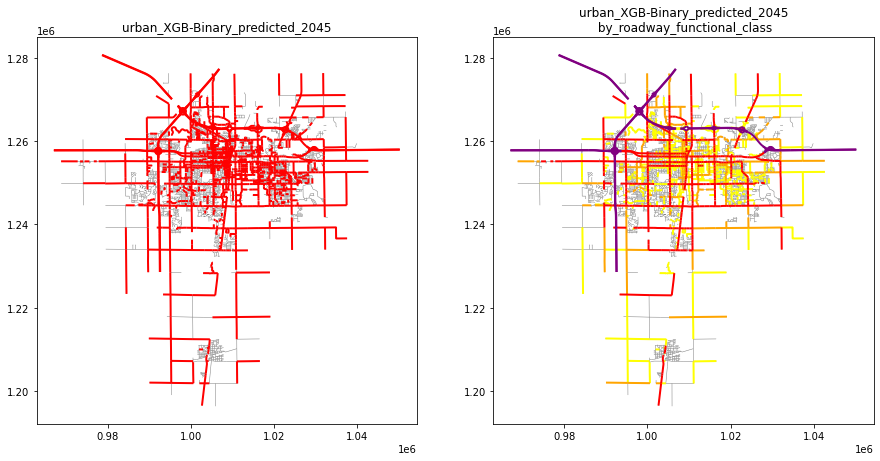

In [28]:
year = 2045
segment_intersection='segment'
model_geography='urban'
model_name = 'XGB-Binary'
map_name = model_geography+'_'+model_name+'_predicted_'+str(year)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
df_rural_test_2045  = gpd.GeoDataFrame(df_urban_test_2045 , geometry=df_urban_test_2045['geometry'])
prediction_binary_maps (ax1,df_urban_test_2045, df_urban_test_2045, Binary_y_pred_2045, year)
ax1.set_title(map_name)
prediction_binary_maps_byrdclass (ax2,df_urban_test_2045, df_urban_test_2045, Binary_y_pred_2045, year)
ax2.set_title(map_name+'\n by_roadway_functional_class')

## Multi-class Model
[[back to top](#sections)]

In [29]:
# Multiclass model prediction results
Multiclass_y_pred_2019 = urban_multiclass_xgb.predict(X_test_OHtransformed_2019) 
Multiclass_y_pred_2045 = urban_multiclass_xgb.predict(X_test_OHtransformed_2045) 


Text(0.5, 1.0, 'urban_XGB-MultiClass_predicted2045')

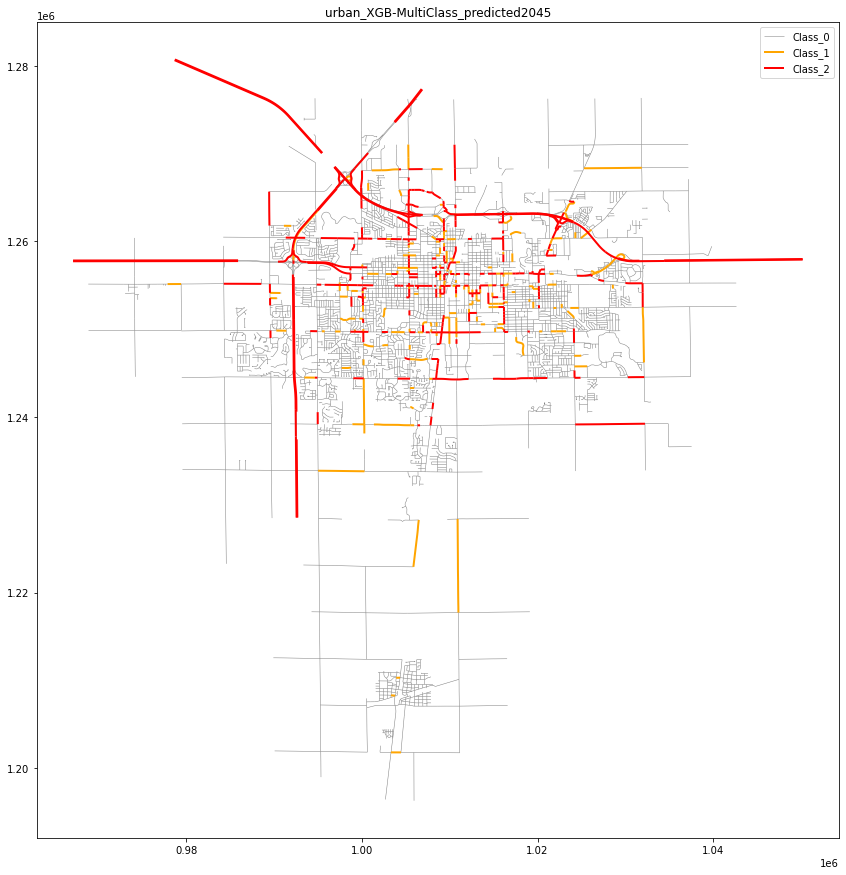

In [30]:
year = 2045
segment_intersection='segment'
model_geography='urban'
model_name = 'XGB-MultiClass'
map_name = model_geography+'_'+model_name+'_predicted'+str(year)
fig, axes = plt.subplots(figsize=(15,15))
plt_multiclass_prediction_maps (axes, df_urban_test_2045, Multiclass_y_pred_2045, year)
plt.title(map_name)

## Binary Model + Multi-class Model
[[back to top](#sections)]

### Predicted 2045
[[back to top](#sections)]

In [31]:
BinaryMulticlass_results = df_urban_test_2045.loc[:,['segment_id','geometry']].copy()
BinaryMulticlass_results['Binary'] = Binary_y_pred_2045
BinaryMulticlass_results['MultiClass'] = Multiclass_y_pred_2045

risklevelcounts_2045 = pd.crosstab(BinaryMulticlass_results['Binary'],BinaryMulticlass_results['MultiClass'])
print('Number of low risk roads:',risklevelcounts_2045.loc[0,0])
print('Number of medium risk roads:',risklevelcounts_2045.sum().sum() - risklevelcounts_2045.loc[0,0] - risklevelcounts_2045.loc[1,2])
print('Number of high risk roads:',risklevelcounts_2045.loc[1,2],'\n')

risklevelcounts_2045

Number of low risk roads: 4227
Number of medium risk roads: 1813
Number of high risk roads: 318 



MultiClass   0.0  1.0  2.0
Binary                    
0           4227    2    0
1           1620  191  318

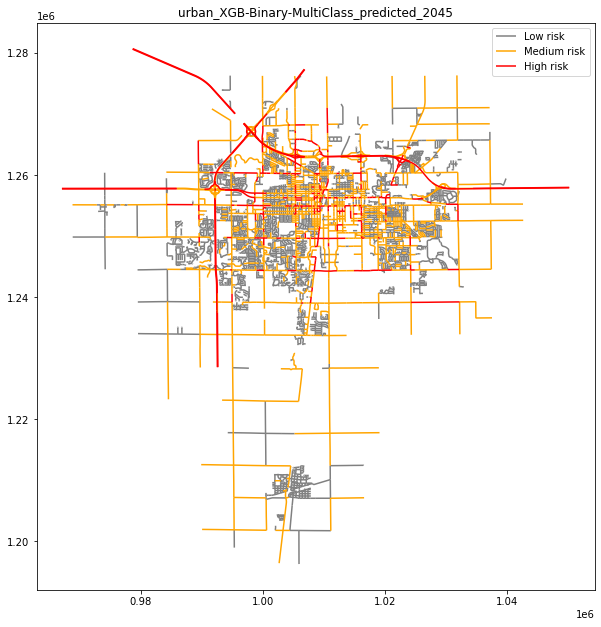

In [32]:
# map low risk, medium risk, high risk roads
year = 2045
segment_intersection='segment'
model_geography='urban'
model_name = 'XGB-Binary-MultiClass'
map_name = model_geography+'_'+model_name+'_predicted_'+str(year)

plt_low_medium_high_risk_roads(BinaryMulticlass_results,map_name)

### Predicted 2045 VS predicted 2019
[[back to top](#sections)]

In [33]:
BinaryMulticlass_results = df_urban_test_2019.loc[:,['segment_id','geometry']].copy()
BinaryMulticlass_results['Binary'] = Binary_y_pred_2019
BinaryMulticlass_results['MultiClass'] = Multiclass_y_pred_2019

risklevelcounts_2019 = pd.crosstab(BinaryMulticlass_results['Binary'],BinaryMulticlass_results['MultiClass'])
print('Number of low risk roads:',risklevelcounts_2019.loc[0,0])
print('Number of medium risk roads:',risklevelcounts_2019.sum().sum() - risklevelcounts_2019.loc[0,0] - risklevelcounts_2019.loc[1,2])
print('Number of high risk roads:',risklevelcounts_2019.loc[1,2],'\n')

risklevelcounts_2019

Number of low risk roads: 4152
Number of medium risk roads: 1817
Number of high risk roads: 389 



MultiClass   0.0  1.0  2.0
Binary                    
0           4152    6    0
1           1532  279  389

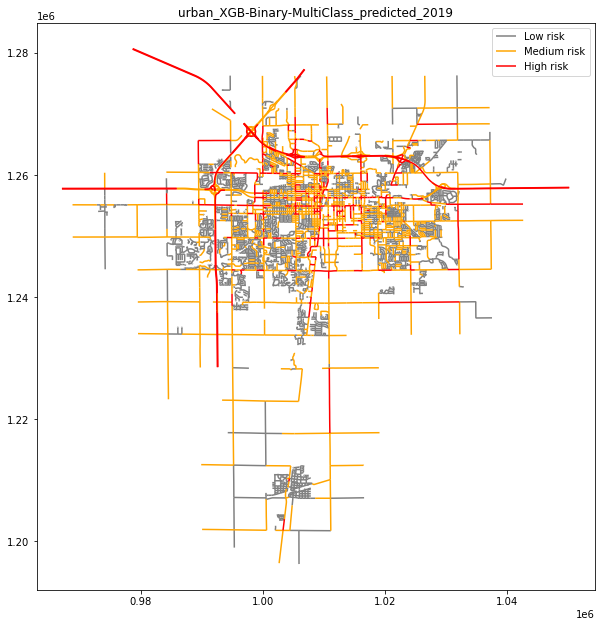

In [34]:
# map low risk, medium risk, high risk roads
year = 2019
segment_intersection='segment'
model_geography='urban'
model_name = 'XGB-Binary-MultiClass'
map_name = model_geography+'_'+model_name+'_predicted_'+str(year)

plt_low_medium_high_risk_roads(BinaryMulticlass_results,map_name)